In [1]:
# normal imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
train.columns = train.columns.str.lower()
orig_train = train.copy()
train.head(1)

,id,podcast_name,episode_title,episode_length_minutes,genre,host_popularity_percentage,publication_day,publication_time,guest_popularity_percentage,number_of_ads,episode_sentiment,listening_time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998


In [3]:
# for kaggle 
# %load_ext cudf.pandas 
pd.set_option('display.max_columns', 500)

In [4]:
test = pd.read_csv('test.csv')
test.columns = test.columns.str.lower()
test.head(1)

,id,podcast_name,episode_title,episode_length_minutes,genre,host_popularity_percentage,publication_day,publication_time,guest_popularity_percentage,number_of_ads,episode_sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral


In [5]:
y_train = train["listening_time_minutes"]
train = train.drop(["listening_time_minutes"], axis=1)
combined = pd.concat([train, test])

In [6]:
combined["number_of_ads"] = combined["number_of_ads"].fillna(0)

In [7]:
# encode day cyclically  
days_dict = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}
def periodic_encode(data, map_dict, num_periods):
    if map_dict is not None:    
        data = [map_dict[x] for x in data]
    return np.cos(2 * np.pi * np.array(data) / num_periods), np.sin(2 * np.pi * np.array(data) / num_periods) 

combined["day_cos"], combined["day_sin"] = periodic_encode(combined["publication_day"], days_dict, 7) 

In [8]:
# encode time cyclically
time_dict = {
    "Morning": 9, 
    "Afternoon": 12, 
    "Evening": 18,
    "Night": 22
}

combined["time_cos"], combined["time_sin"] = periodic_encode(combined["publication_time"], time_dict, 24)

In [9]:
# encode sentiment numerically 
sentiment_dict = {
    "Negative": -1, 
    "Neutral" : 0,
    "Positive": 1
}

combined["sentiment_num"] = combined["episode_sentiment"].map(sentiment_dict)

In [10]:
# encode epsiode title numerically
combined["episode_title"] = [int(x[8:]) for x in combined["episode_title"]]

In [11]:
# get categorical columns
cat_cols = combined.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['podcast_name', 'genre', 'publication_day', 'publication_time',
       'episode_sentiment'],
      dtype='object')


In [12]:
# encode categorical data
dummies = pd.get_dummies(combined[cat_cols], dtype=int)
combined = pd.concat([combined, dummies], axis=1)

In [13]:
# NaN columns
combined["NaNs"] = np.float32(0)

nan_cols = combined.columns[combined.isna().any()]

COMBO = ["NaNs"]
for i, c in enumerate(nan_cols):
    combined["NaNs"] += combined[c].isna()*2**i

    name_ads = f"{c}_nan_ads"
    combined[name_ads] = combined[c].isna()*100 + combined["number_of_ads"]

    name_sent = f"{c}_nan_sent"
    combined[name_sent] = combined[c].isna()*100 + combined["sentiment_num"]

    name_host_pop = f"{c}_nan_host_pop"
    combined[name_host_pop] = combined[c].isna()*100 + combined["host_popularity_percentage"]

    COMBO.extend([name_ads, name_sent, name_host_pop])

In [14]:
# cat combos 
for i, c in enumerate(cat_cols):
    factorize, _ = pd.factorize(combined[c])

    name_ads = f"{c}_ads"
    combined[name_ads] = factorize*100 + combined["number_of_ads"]

    name_sent = f"{c}_sent"
    combined[name_sent] = factorize*100 + combined["sentiment_num"]

    name_host_pop = f"{c}_host_pop"
    combined[name_host_pop] = factorize*100 + combined["host_popularity_percentage"]

    COMBO.extend([name_ads, name_sent, name_host_pop])

In [15]:
# multiple categorical combos
for i, c1 in enumerate(cat_cols[:-1]):
    for j, c2 in enumerate(cat_cols[i+1:]):
        n = f"{c1}_sum_{c2}"
        factorize_c1, _ = pd.factorize(combined[c1])
        factorize_c2, _ = pd.factorize(combined[c2])
        
        mul_n = f"{c1}_mul_{c2}"
        combined[n] = factorize_c1 + factorize_c2
        combined[mul_n] = factorize_c1 * factorize_c2

In [16]:
for i in combined.columns: 
    if combined[i].isna().sum() > 0:
        
        print(f"{i} has {combined[i].isna().sum()} missing values")

episode_length_minutes has 115829 missing values
guest_popularity_percentage has 194862 missing values


In [17]:
# selecting rows that don't have NaN values for both nan filled columns
elm_nan_idx = combined["episode_length_minutes"].isna()
gpp_nan_idx = combined["guest_popularity_percentage"].isna()

In [44]:
def display_results(model, data):
    # Feature importance
    feature_importance = pd.Series(model.feature_importances_, index=data.columns)
    feature_importance = feature_importance.sort_values(ascending=False)
    feature_importance[:10].plot(kind='barh', figsize=(10, 6))

    print("\n🔍 Top 10 Feature Importances:")
    print(feature_importance.head(10))
    return feature_importance


In [19]:
from sklearn.model_selection import train_test_split

def show_score(data, target, model):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    print(f"R^2 is {model.score(X_test, y_test)}")

In [21]:
# imputing with xgboost
from xgboost import XGBRegressor

drop_cols = cat_cols.to_list()
drop_cols.append("id")
combined_wo_cats = combined.drop(drop_cols, axis=1)

elm_imp_model = XGBRegressor(random_state=42)
gpp_imp_model = XGBRegressor(random_state=42)

elm_imp_model.fit(combined_wo_cats.drop(nan_cols, axis=1)[~elm_nan_idx], combined_wo_cats.loc[~elm_nan_idx, "episode_length_minutes"])
gpp_imp_model.fit(combined_wo_cats.drop(nan_cols, axis=1)[~gpp_nan_idx], combined_wo_cats.loc[~gpp_nan_idx, "guest_popularity_percentage"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [22]:
# validation for imputing 
show_score(combined_wo_cats.drop(nan_cols, axis=1)[~elm_nan_idx], combined_wo_cats.loc[~elm_nan_idx, "episode_length_minutes"], XGBRegressor(random_state=42))
show_score(combined_wo_cats.drop(nan_cols, axis=1)[~gpp_nan_idx], combined_wo_cats.loc[~gpp_nan_idx, "guest_popularity_percentage"], XGBRegressor(random_state=42))

R^2 is 0.017993241717660258
R^2 is 0.004951337764688257


In [23]:
# imputing missing vlaues 
combined.loc[elm_nan_idx, "episode_length_minutes"] = elm_imp_model.predict(combined_wo_cats.drop(nan_cols, axis=1)[elm_nan_idx])
combined.loc[gpp_nan_idx, "guest_popularity_percentage"] = gpp_imp_model.predict(combined_wo_cats.drop(nan_cols, axis=1)[gpp_nan_idx])

In [47]:
# popularity combinations
combined["popularity_sum"] = combined["host_popularity_percentage"] + combined["guest_popularity_percentage"]
combined["popularity_prod"] = combined["host_popularity_percentage"] * combined["guest_popularity_percentage"]
combined["popularity_diff"] = combined["host_popularity_percentage"] - combined["guest_popularity_percentage"]
combined["popularity_diff_sq"] = (combined["host_popularity_percentage"] - combined["guest_popularity_percentage"])**2
POP_COMBOS = ["popularity_sum", "popularity_prod", "popularity_diff", "popularity_diff_sq"]

In [29]:
X_train = combined.drop(drop_cols, axis=1).iloc[:750000]
X_train["Price"] = y_train

In [31]:
tmp = X_train.groupby("popularity_sum")["Price"].agg(np.mean)

C:\Users\hollanderj\AppData\Local\Temp\ipykernel_13420\3967488941.py:1: FutureWarning: The provided callable <function mean at 0x000002010E35C0E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  tmp = X_train.groupby("popularity_sum")["Price"].agg(np.mean)


In [53]:
train = combined.drop(drop_cols, axis=1).iloc[:750000]
train["target"] = y_train
test = combined.drop(drop_cols, axis=1).iloc[750000:]

In [ ]:
from sklearn.model_selection import KFold

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros((len(train)))
pred = np.zeros((len(test)))

# OUTER K FOLD
for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(f"### OUTER Fold {i+1} ###")

    X_train = train.iloc[train_index].reset_index(drop=True).copy()
    y_train = train.loc[train_index,"target"]

    X_valid = train.iloc[test_index].reset_index(drop=True).copy()
    y_valid = train.loc[test_index,"target"]

    X_test = test.reset_index(drop=True).copy()

    # INNER K FOLD (TO PREVENT LEAKAGE WHEN USING PRICE)
    kf2 = KFold(n_splits=FOLDS, shuffle=True, random_state=42)   
    for j, (train_index2, test_index2) in enumerate(kf2.split(X_train)):
        print(f" ## INNER Fold {j+1} (outer fold {i+1}) ##")

        X_train2 = X_train.loc[train_index2,FEATURES+['Price']].copy()
        X_valid2 = X_train.loc[test_index2,FEATURES].copy()

        ### FEATURE SET 1 (uses price) ###
        col = "Weight Capacity (kg)"
        tmp = X_train2.groupby(col).Price.agg(STATS)
        tmp.columns = [f"TE1_wc_{s}" for s in STATS]
        X_valid2 = X_valid2.merge(tmp, on=col, how="left")
        for c in tmp.columns:
            X_train.loc[test_index2,c] = X_valid2[c].values.astype("float32")

        ### FEATURE SET 2 (uses price) ###
        for col in COMBO:
            tmp = X_train2.groupby(col).Price.agg(STATS2)
            tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
            X_valid2 = X_valid2.merge(tmp, on=col, how="left")
            for c in tmp.columns:
                X_train.loc[test_index2,c] = X_valid2[c].values.astype("float32")

        # AGGREGATE QUANTILES (uses price)
        for k in QUANTILES:
            result = X_train2.groupby('Weight Capacity (kg)').agg({'Price': lambda x: x.quantile(k/100)})
            result.columns = [f"quantile_{k}"]
            X_valid2 = X_valid2.merge(result, on="Weight Capacity (kg)", how="left")
            X_train.loc[test_index2,f"quantile_{k}"] = X_valid2[f"quantile_{k}"].values.astype("float32")

        # AGGREGATE HISTOGRAMS (uses price)
        tmp = X_train2.loc[~X_train2.orig_price.isna()].groupby("Weight Capacity (kg)")[["Price"]].agg("count")
        tmp.columns = ['ct']
        X_train3 = X_train2.merge(tmp.loc[tmp['ct']>1],on="Weight Capacity (kg)",how="left")
        X_train3 = X_train3.loc[~X_train3['ct'].isna()]
        result = X_train3.groupby("Weight Capacity (kg)")["Price"].apply(make_histogram)
        result = result.to_frame()['Price'].apply(pd.Series)
        result.columns = [f"histogram_{x}" for x in range(BINS)]
        X_valid2 = X_valid2.merge(result, on="Weight Capacity (kg)", how="left")
        for c in [f"histogram_{x}" for x in range(BINS)]:
            X_train.loc[test_index2,c] = X_valid2[c].values.astype("float32")
            
        del result, X_train3, tmp
        del X_train2, X_valid2
        gc.collect()

    ### FEATURE SET 1 (uses price) ###
    col = "Weight Capacity (kg)"
    tmp = X_train.groupby(col).Price.agg(STATS)
    tmp.columns = [f"TE1_wc_{s}" for s in STATS]
    tmp = tmp.astype("float32")
    X_valid = X_valid.merge(tmp, on=col, how="left")
    X_test = X_test.merge(tmp, on=col, how="left")

    ### FEATURE SET 2 (uses price) ###
    for col in COMBO:
        tmp = X_train.groupby(col).Price.agg(STATS2)
        tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
        tmp = tmp.astype("float32")
        X_valid = X_valid.merge(tmp, on=col, how="left")
        X_test = X_test.merge(tmp, on=col, how="left")

    # AGGREGATE QUANTILES (uses price)
    for k in QUANTILES:
        result = X_train.groupby('Weight Capacity (kg)').agg({'Price': lambda x: x.quantile(k/100)})
        result.columns = [f"quantile_{k}"]
        result = result.astype("float32")
        X_valid = X_valid.merge(result, on="Weight Capacity (kg)", how="left")
        X_test = X_test.merge(result, on="Weight Capacity (kg)", how="left")

    # AGGREGATE HISTOGRAMS (uses price)
    tmp = X_train.loc[~X_train.orig_price.isna()].groupby("Weight Capacity (kg)")[["Price"]].agg("count")
    tmp.columns = ['ct']
    X_train3 = X_train.merge(tmp.loc[tmp['ct']>1],on="Weight Capacity (kg)",how="left")
    X_train3 = X_train3.loc[~X_train3['ct'].isna()]
    result = X_train3.groupby("Weight Capacity (kg)")["Price"].apply(make_histogram)
    result = result.to_frame()['Price'].apply(pd.Series)
    result.columns = [f"histogram_{x}" for x in range(BINS)]
    result = result.astype("float32")
    X_valid = X_valid.merge(result, on="Weight Capacity (kg)", how="left")
    X_test = X_test.merge(result, on="Weight Capacity (kg)", how="left")
    del result, X_train3, tmp

    # COUNT PER NUNIQUE
    X_train['TE1_wc_count_per_nunique'] = X_train['TE1_wc_count']/X_train['TE1_wc_nunique']
    X_valid['TE1_wc_count_per_nunique'] = X_valid['TE1_wc_count']/X_valid['TE1_wc_nunique']
    X_test['TE1_wc_count_per_nunique'] = X_test['TE1_wc_count']/X_test['TE1_wc_nunique']
    
    # STD PER COUNT
    X_train['TE1_wc_std_per_count'] = X_train['TE1_wc_std']/X_train['TE1_wc_count']
    X_valid['TE1_wc_std_per_count'] = X_valid['TE1_wc_std']/X_valid['TE1_wc_count']
    X_test['TE1_wc_std_per_count'] = X_test['TE1_wc_std']/X_test['TE1_wc_count']

    # CONVERT TO CATS SO XGBOOST RECOGNIZES THEM
    X_train[CATS+DIGITS] = X_train[CATS+DIGITS].astype("category")
    X_valid[CATS+DIGITS] = X_valid[CATS+DIGITS].astype("category")
    X_test[CATS+DIGITS] = X_test[CATS+DIGITS].astype("category")

    # DROP PRICE THAT WAS USED FOR TARGET ENCODING
    X_train = X_train.drop(['Price'],axis=1)

    # DROP NON-TE CAT PAIRS
    X_train = X_train.drop(PAIRS,axis=1)
    X_valid = X_valid.drop(PAIRS,axis=1)
    X_test = X_test.drop(PAIRS,axis=1)

    # BUILD MODEL
    model = XGBRegressor(
        device="cuda",
        max_depth=6,  
        colsample_bynode=0.3, 
        subsample=0.8,  
        n_estimators=50_000,  
        learning_rate=0.01,  
        enable_categorical=True,
        min_child_weight=10,
        early_stopping_rounds=500,
    )
    
    # TRAIN MODEL
    COLS = X_train.columns
    model.fit(
        X_train[COLS], y_train,
        eval_set=[(X_valid[COLS], y_valid)],  
        verbose=500,
    )

    # PREDICT OOF AND TEST
    oof[test_index] = model.predict(X_valid[COLS])
    pred += model.predict(X_test[COLS])

    # CLEAR MEMORY
    del X_train, X_valid, X_test
    del y_train, y_valid
    if i != FOLDS-1: del model
    gc.collect()

pred /= FOLDS

0    31.41998
1    88.01241
2    88.01241
3    88.01241
4    88.01241
5    88.01241
6    88.01241
7    88.01241
8    88.01241
9    88.01241
Name: Price, dtype: float64

In [35]:
# now evaluating nan columns 
for i in combined.columns: 
    if combined[i].isna().sum() > 0:
        print(f"{i} has {combined[i].isna().sum()} missing values")

In [36]:
# final model
model = XGBRegressor()

In [37]:
# split the data into training and testing
final_X_train, final_y_train = np.array(combined.drop(drop_cols, axis=1).iloc[:750000]), np.array(y_train)
model.fit(final_X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)


🔍 Top 10 Feature Importances:
episode_length_minutes                   0.665029
episode_length_minutes_nan_ads           0.027790
number_of_ads                            0.008162
episode_sentiment_ads                    0.007134
genre_Business                           0.006122
genre_Technology                         0.005691
host_popularity_percentage               0.005394
genre_Sports                             0.005275
publication_day_mul_episode_sentiment    0.005193
podcast_name_News Roundup                0.004882
dtype: float32


episode_length_minutes            0.665029
episode_length_minutes_nan_ads    0.027790
number_of_ads                     0.008162
episode_sentiment_ads             0.007134
genre_Business                    0.006122
                                    ...   
episode_sentiment_Positive        0.000000
podcast_name_Tune Time            0.000000
publication_day_Saturday          0.000000
episode_sentiment_sent            0.000000
publication_day_Monday            0.000000
Length: 128, dtype: float32

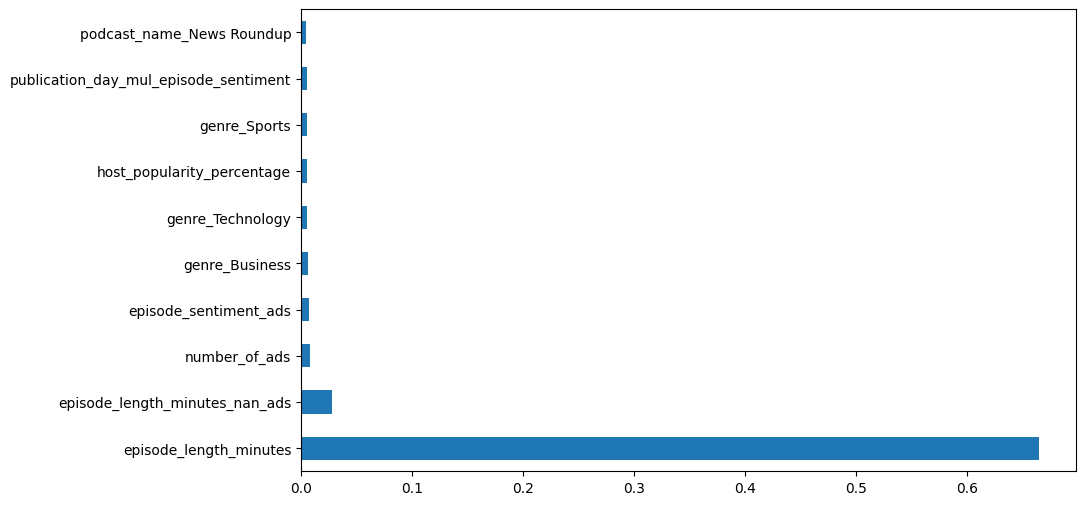

In [52]:
display_results(model, train)

In [331]:
submission = pd.read_csv('sample_submission.csv')

In [333]:
submission["Listening_Time_minutes"] = model.predict(combined.drop(drop_cols, axis=1).iloc[750000:])

In [335]:
submission.to_csv("submission2.csv", index=False)